<a href="https://colab.research.google.com/github/josegoisgit/dadosgov/blob/main/dados_de_governos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bandeiras

1.   Transparência digital
2.   Dados abertos



Informações

https://dados.gov.br/pagina/sobre

https://www.oecd.org/gov/open-government-data-report-9789264305847-en.htm

http://www.oecd.org/gov/digital-government/open-government-data.htm

https://en.wikipedia.org/wiki/Open_by_default

https://theunitedstates.io/licensing

https://www.w3.org/2017/12/odi-study/

https://www.w3.org/TR/vocab-dcat/

In [36]:
# alias_url = {
#     'Australia' : 'data.gov.au',
#     'Austria' : 'data.gv.at',
#     'Belgium' : 'data.gov.be',
#     'Brazil'  : 'dados.gov.br',
#     'Canada' : 'open.canada.ca',
#     'Chile' : 'datos.gob.cl',
#     'Colombia' :'datos.gob.co',
#     'Denmark' : 'www.digitaliser.dk/cataloues',
#     'Dominican Republic' : 'www.datos.gob.do',
#     'Estonia' : 'opendata.riik.ee',
#     'Finland' : 'avoindata.fi/fi',
#     'France' : 'data.gouv.fr',
#     'Germany' : 'govdata.de',
#     'Greece' : 'data.gov.gr',
#     'Ireland' : 'data.gov.ie',
#     'Israel' : 'data.gov.il',
#     'Italy' : 'dati.gov.it',
#     'Japan' : 'data.go.jp',
#     'Korea' : 'data.go.kr',
#     'Latvia' : 'data.gov.lv',
#     'Lithuania' : 'data.gov.lt',
#     'Mexico' : 'datos.gob.mx',
#     'Netherlands' : 'data.overheid.nl',
#     'Norway' : 'data.norge.no',
#     'Peru' : 'datosabiertos.gob.pe',
#     'Poland' : 'danepubliczene.gov.pl',
#     'Portugal' : 'dados.gov.pt',
#     'Slovenia' : 'data.gov.si',
#     'Spain' : 'datos.gob.es',
#     'Sweden' : 'oppnadata.se',
#     'Switzeland' : 'opendata.swiss',
#     'Czech Republic' : 'data.gov.cz',
#     'New Zealand' : 'data.govt.nz',
#     'Slovak Republic' : 'data.gov.sk',
#     'United Kingdom' : 'data.gov.uk',
#     'Uniteds States' : 'data.gov'
# }

In [37]:
alias_url = {
    'Brazil'  : 'dados.gov.br',
    'Dominican Republic' : 'www.datos.gob.do',
}

In [38]:
#alias = 'Dominican Republic'
#query     = 'estudio'

In [39]:
alias = 'Brazil'
query = 'biblioteca'

In [40]:
hyperlink = 'https://'+alias_url[alias]

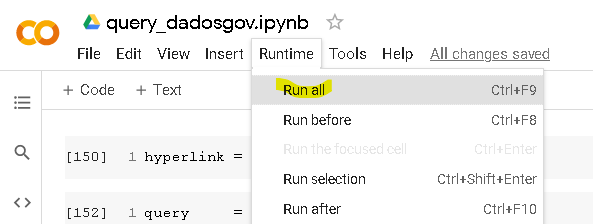

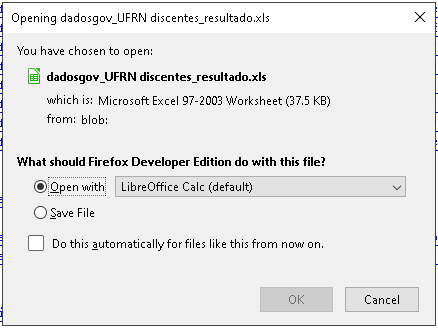

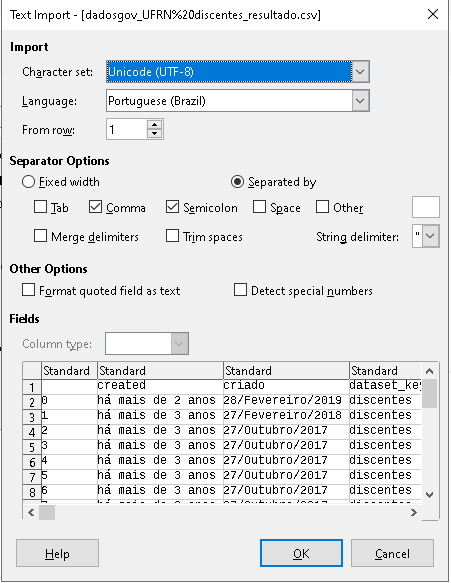

# Módulos e pacotes

## Instalação

In [41]:
!pip install unidecode
!pip install pymupdf


## Importação

In [42]:
import re
import fitz
import requests
import pandas

from unidecode import unidecode

from itertools import chain
from lxml.etree import HTML

import IPython
import ipywidgets
import google.colab

# Funções

## auxiliares

#### lambdas

##### strip

In [43]:
strip_ = lambda T: set( t.strip() for t in T if t.strip() )
strip  = lambda T: '\n'.join( strip_( T ) ).strip()

##### plain

In [44]:


plain  = lambda I: list( chain.from_iterable( I ) )


## get_url_html

In [45]:
def get_url_html(url):
    requested         = requests.request('GET', url)
    html              = HTML(requested.text)    
    html.nsmap['url'] = url

    return html


## xpath

### contains_clause

In [46]:
def contains_clause(dic, operator='OR'):
    predicados = ["contains(@{k},'{v}')".format(k=k,v=v) for k,v in dic.items()]

    return operator.join(predicados)


### compose_xpath

In [47]:

def compose_xpath(element,attribute,content):
    dictionary = contains_clause({attribute:content})

    str_dict = {
        'element' : element,
        'dictionary' : dictionary 
    }

    return "{element}[{dictionary}]".format(**str_dict)


### get_xnodes

In [48]:

def get_xnodes(html, element, attribute='class', content='', complement=''):
    if complement:
        xnode = html.xpath(compose_xpath(element,attribute,content) + complement)
    else:
        xnode = html.xpath(compose_xpath(element,attribute,content) )
    return xnode if xnode else None


### get_xnode

In [49]:

def get_xnode(html, element, attribute='class', content='', complement=''):
    xnodes = get_xnodes(html, element, attribute, content, complement)
    return xnodes[0] if xnodes else None


## datasets

### get_html_page_count

In [50]:
 
def get_html_page_count(html):
    xnode = get_xnode( html, '//div', 'class', 'pagination' ) 
    
    if xnode is None:
        return 1
    
    pdiv = xnode.xpath( '//li/a/text()' )
    
    def pmax(pdiv):
        V = [1]
        for p in pdiv:
            try:
                v = int(p)
                V.append(v)       
            except:
                continue
        return max(V)    
    return pmax(pdiv)

### get_query_page_count

In [51]:

def get_query_page_count(hyperlink,query):
    html = get_url_html( hyperlink + '/dataset?q=%s' % query)
    return get_html_page_count( html )


### get_html_items_href






In [52]:

def get_html_items_href(html):
    xnodes = get_xnodes( html, './/h3', 'class', 'dataset-heading' , '//a/@href' ) 
    return xnodes


### get_html_dataset

In [53]:

def get_html_dataset(html):    
    article_html = get_xnode(html , '//article')
    
    dataset = dict()
    
    dataset['organization'] = ' '.join([x.strip() for x in get_xnodes(html, './/section','class','module-content','//h1//text()')])
    dataset['title']        = strip( get_xnodes( article_html , 'div/h1/text()') ) 
    dataset['key']          = re.sub('[^\w]','_',unidecode(dataset['title']).lower())
    z = get_xnodes(article_html,'//div','class','notes','//p/text()')
    dataset['text'] = strip(z) if z else ''
    dataset['url']          = get_xnodes( article_html, '//ol', 'class', 'breadcrumb', '//li/a/@href')

    return dataset


### get_html_dataset_license

In [54]:

def get_html_dataset_license(html,hyperlink='https://dados.gov.br'):
    xnode = get_xnode( html, '//section','class','license') 

    if not xnode: return dict(title='NA',href='',text='',logo='')

    license_title = xnode.xpath( './/@title' )
    license_href  = xnode.xpath( './/@href')
    license_text  = [ text.strip() for text in xnode.xpath( './/text()' ) if text.strip() ]
    license_logo  = [ hyperlink + p for p in xnode.xpath( './/img//@src' ) ]
    
    license_dict          = dict()
    license_dict['title'] = license_title
    license_dict['href']  = license_href
    license_dict['text']  = license_text
    license_dict['logo']  = license_logo

    return license_dict


### get_html_dataset_resources_href

In [55]:

def get_html_dataset_resources_href(html):
    return get_xnodes(html,'//a','class','heading','/@href')


### get_html_resource_info





In [211]:
def get_html_resource_info(html):
    
    ths     = get_xnodes( html, '//table', 'class', 'table-condensed','/tbody//th/text()')
    headers = [re.sub('[^\w]','_',unidecode(th.lower())) for th in ths]
    tds     = get_xnodes( html, '//table', 'class', 'table-condensed','/tbody//td')
    data    = [strip(get_xnodes(td, './/text()')).strip() for td in tds]



    content = get_xnode( html, '//div','class','module-content')


    info_dict        = {h:d for h,d in zip(headers,data)}
    info_dict['url'] = str(get_xnode( html, '//a','class','resource-url-analytic','/@href'))
    
    info_dict['title'] = str(get_xnode( content, './/h1', 'class', 'page-heading','//text()'))
    info_dict['description'] = str(get_xnode( content, './/div', 'class', 'prose notes','//text()'))

    return info_dict

### auxiliares

#### \_\_dir_repr\_\_

In [57]:

def __dir_repr__(variable=dict,pattern=''):
    dir_type_dict = dict()
    
    for attribute in dir(variable):
        if not re.findall(pattern, attribute): continue
        value = getattr(variable,attribute)
        typename = type(value).__name__
        
        if typename not in dir_type_dict:
            dir_type_dict[typename] = [(attribute,value)]
        else:
            dir_type_dict[typename].append((attribute,value))
        
    for key, items in dir_type_dict.items():
        print(key)
        print()
        for attribute,value in items:
            print('\t',attribute)
        print()
        #print('{: <30s}{:<20s}'.format(typename, attribute))


#### show_url

In [58]:

def show_url( url='https://'+hyperlink ):
    dadosgov_frame = IPython.display.IFrame(src=url,width='100%',height='500px')
    display(dadosgov_frame)
    return


#### query_site

In [59]:

def query_site( query=''):
    query = query.lower()
    query = unidecode.unidecode(query)
    query = re.sub('[^a-z\s\'\"]','',query)
    query = re.sub('\s+','+',query)
    
    url = hyperlink='/dataset?q=%s' % query
    dadosgov_frame = IPython.display.IFrame(src=url,width='100%',height='500px')
    display(dadosgov_frame)
    return dadosgov_frame



#### lambdas

##### get_query_page_url

In [60]:
get_query_page_url   = lambda h, q, p : h + '/dataset' + '?q=' + q + ( ( '&page=' + str(p) ) if ( p > 1 ) else '' )

##### get_query_page_html

In [61]:
get_query_page_html  = lambda h, q, p : get_url_html( get_query_page_url( h, q, p ) )


##### get_query_page_items

In [62]:
get_query_page_items = lambda h, q, p : get_html_items_href( get_query_page_html( h, q, p ) )


##### get_query_items_href

In [63]:
get_query_items_href = lambda h, q    : plain([ get_query_page_items( h, q, p+1 ) for p in range( get_query_page_count( h, q ) ) ])


# Leitura

## argumentos

In [64]:
query   = re.sub('[^\w]',' ',unidecode(query))
query   = re.sub('\s+'  ,' ',query)
query   = re.sub('\s'   ,'+',query)

query

'biblioteca'

In [65]:
query_url = get_query_page_url(hyperlink,query,1)

In [66]:
print(query_url)


https://dados.gov.br/dataset?q=biblioteca


In [67]:
show_url(query_url)

## visualização

In [77]:
resources = []

In [78]:
items_href = []
page_count = get_query_page_count( hyperlink , query )
page_count

7

In [79]:
for page in range( page_count ):
    print('page {page} of {page_count}'.format(page_count=page_count,page=page+1) )
    html = get_query_page_html( hyperlink, query, page+1 )
    html_items = get_html_items_href(html)
    tuple(map(lambda item: print('\t',item[9:]), html_items));
    items_href += html_items

page 1 of 7
	 biblioteca
	 unipampa-bibliotecas
	 acervo-da-biblioteca
	 acervo-biblioteca
	 biblioteca-digital-funag-2020
	 biblioteca-digital-funag-2019
	 biblioteca-digital-funag-2018
	 acervo-da-real-biblioteca
	 biblioteca-digital-funag-2017
	 biblioteca-digital-funag-2016
	 sistema-nacional-de-bibliotecas-publicas
	 emprestimos-acervos-das-bibliotecas
	 biblioteca-total-de-titulos-e-exemplares
	 biblioteca-total-de-emprestimos-por-vinculo
	 base-de-dados-da-biblioteca-curt-nimuendaju
	 acervo-aquisicao
	 acervo-bibliografico
	 unipampa-acervo-bibliografico
	 quantidade-de-teses-e-dissertacoes
	 bibliotecas-do-ifsp
page 2 of 7
	 acervo-biblioteca-edimundo-moniz
	 existencia-de-biblioteca-nos-estabelecimentos-prisionais-segundo-uf-2018
	 arca-das-letras-bibliotecas-para-o-brasil-rural
	 acervo-bibliografico1
	 acervo-digital
	 acervo-impresso
	 bolsas-de-extensao-cultura-e-sibi
	 acervo-bibliografico-adquirido
	 repositorio-institucional
	 equipamentos-mantidos-pela-gestao-estadual

In [80]:
ih = 0
 
print(hyperlink + items_href[ih])
show_url(hyperlink + items_href[ih])

https://dados.gov.br/dataset/biblioteca


## arquivos

In [81]:
import time

In [82]:
import pandas
resources = []
for item_href in items_href:
    item_url = hyperlink + item_href
 
    print('\n\n\t', item_url, end='\n\n')
    dataset_html   = get_url_html( item_url )
 
    dataset        = get_html_dataset( dataset_html )
    license        = get_html_dataset_license ( dataset_html )
    resources_href = get_html_dataset_resources_href( dataset_html )
 
    for resource_href in resources_href:
        resource_url  = hyperlink + resource_href 
 
        resource_html = get_url_html( resource_url )  
        resource_dict = get_html_resource_info(resource_html)
 
        a = 'http://landpage-h.cgu.gov.br/dadosabertos/index.php?url='
        resource_dict['url_out'] = resource_dict['url'].replace(a,'') if resource_dict['url'] else None        

        resource_dict.update({('dataset_'+k):v for k,v in dataset.items()})
        resource_dict.update({('license_'+k):v for k,v in license.items()})
 
        resource_dict['havested'] = time.ctime()
        
        print('\t\t',resource_dict['url_out'], end='\n')
 
        resources.append( resource_dict )



	 https://dados.gov.br/dataset/biblioteca



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  """


		 http://api.ufersa.edu.br:8080/apiufersa/rest/pda/biblioteca-materiais-tipo
		 http://api.ufersa.edu.br:8080/apiufersa/rest/pda/biblioteca-materiais-emprestados
		 http://dadosabertos.ufersa.edu.br/dataset/72c37142-a727-4e77-bf00-8a2062968334/resource/37686a75-52e0-4386-bb32-94ece1ffb585/download/pda-ufersa-2019_2021-dicionario-de-dados-tipologiaacervobot.csv
		 http://dadosabertos.ufersa.edu.br/dataset/72c37142-a727-4e77-bf00-8a2062968334/resource/5bc39829-f18d-48dc-9191-409a5bda0943/download/pda-ufersa-2019_2021-dicionario-de-dados-emprestimos_bot.csv


	 https://dados.gov.br/dataset/unipampa-bibliotecas

		 https://dados.unipampa.edu.br/dataset/d7682c0d-9293-43e3-8fdc-2818ab5699de/resource/f4009d81-81ed-4c03-bf4a-551ed03e0934/download/biblioteca.csv
		 https://dados.unipampa.edu.br/dataset/d7682c0d-9293-43e3-8fdc-2818ab5699de/resource/2861f7dc-787b-48e5-a25e-ddd0f9210db3/download/bibliotecas-dicionario-de-dados.pdf
		 https://dados.unipampa.edu.br/dataset/d7682c0d-9293-43e3-8fdc-2

# Dados

In [83]:
df_datagov = pandas.DataFrame(resources)

In [84]:
df_datagov = df_datagov[sorted(df_datagov.keys())]

In [85]:
df_datagov.sample(3).T

,550,160,0
created,há mais de 2 anos,há mais de 2 anos,há mais de 1 ano
criado,12/Junho/2018,6/Novembro/2018,17/Fevereiro/2020
dataset_key,mapa_geologico_da_folha__si_22___lagoa__mirim_...,_2013_a_2016__acessos_ao_portal_de_periodicos,biblioteca
dataset_organization,Instituto Brasileiro de Geografia e Estatístic...,Coordenação de Aperfeiçoamento de Pessoal de N...,Universidade Federal Rural do Semi-Árido - UFE...
dataset_text,Tomando-se como base o mapeamento realizado pe...,O conjunto de dados disponibilizado apresenta ...,Dados referentes ao acervo e serviços do Siste...
dataset_title,Mapa Geológico da Folha SI.22 – Lagoa Mirim ...,[2013 a 2016] Acessos ao Portal de Periódicos,Biblioteca
dataset_url,"[/, /organization, /organization/instituto-bra...","[/, /organization, /organization/coordenacao-d...","[/, /organization, /organization/universidade-..."
datastore_active,NaN,True,True
format,HTML,XLSX,CSV
formato,text/html,XLSX,CSV


In [86]:
FN = lambda ext='json' : './dadosgov_{}_{}_query.{}'.format(alias,query.replace('+','_'), ext)
 
 
df_datagov.to_json(FN('json'))
df_datagov.to_csv(FN('csv'))
df_datagov.to_excel(FN('xls'))
for fn in ['json', 'csv', 'xls']:
    google.colab.files.download(FN(fn))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Leitura do banco de dados

## Funções

### filter_dataset

In [178]:
def filter_dataset(pattern,complement=False):
    id = numpy.full((df_datagov.shape[0],),False)

    dataset_keys = df_datagov.dataset_key.unique()
    
    if complement:
        pattern_keys = [dk for dk in dataset_keys if not re.findall(pattern,dk)]
    else:
        pattern_keys = [dk for dk in dataset_keys if re.findall(pattern,dk)]

    for pk in pattern_keys:
        pk_id = ( (df_datagov.dataset_key == pk).values ) | id
        id = pk_id
    
    return df_datagov[id]

### read_csv

In [202]:
def read_csv(dataset_key = 'discentes'):
    df_dataset = filter_dataset('^'+dataset_key+'$')

    list_dataset = []
    print('dataset '+dataset_key,end='\n\n')
    for entry in df_dataset.iloc:

        if ( ( entry.format == 'CSV' ) is False ) : continue
        print('\t',entry.dataset_title)
        _ = pandas.read_csv(entry.url_out,sep=';',decimal=',')
        list_dataset += [ _ ]
            
    dataset = pandas.concat(list_dataset,axis=0)
    return dataset

### read_pdf

In [171]:
def read_pdf(dataset_key = 'discentes'):
    id_dataset = df_datagov['dataset_key'] == 'discentes'
    df_dataset = df_datagov[id_dataset]
    df_dataset

    list_dataset = []
    print('dataset '+dataset_key,end='\n\n')
    for url in df_dataset['url_out'].values:
        print('\t',url)
        
        ext = os.path.splitext(url)[1]

        if ( ( ext == '.pdf') is False ) : continue
        
        list_dataset += [ url ]
    
    return(list_dataset)
            
    

# Análises

In [203]:
ds = read_csv('biblioteca')

dataset biblioteca

	 Biblioteca
	 Biblioteca
	 Biblioteca
	 Biblioteca


In [210]:
print(hyperlink + df_datagov.iloc[0].dataset_url[-1])

https://dados.gov.br/dataset/biblioteca


In [194]:
pandas.read_csv(filter_dataset('^biblioteca$')['url_out'].values[1],sep=',')

,biblioteca,tipo_material,tipo_emprestimo,ano,mes,qtde_emprestimos
0,BIBLIOTECA CAMPUS ANGICOS,Livro,NORMAL,2010,9,1
1,BIBLIOTECA CAMPUS ANGICOS,Livro,NORMAL,2010,10,1
2,BIBLIOTECA CAMPUS ANGICOS,Livro,NORMAL,2011,2,2
3,BIBLIOTECA CAMPUS ANGICOS,Livro,FOTOCÓPIA,2011,3,1
4,BIBLIOTECA CAMPUS ANGICOS,Livro,NORMAL,2011,3,259
...,...,...,...,...,...,...
1435,BIBLIOTECA CENTRAL - ORLANDO TEIXEIRA,Livro,NORMAL,2020,11,13
1436,BIBLIOTECA CENTRAL - ORLANDO TEIXEIRA,Atlas,NORMAL,2021,1,1
1437,BIBLIOTECA CENTRAL - ORLANDO TEIXEIRA,Livro,NORMAL,2021,1,4
1438,BIBLIOTECA CENTRAL - ORLANDO TEIXEIRA,Livro,NORMAL,2021,2,3


## Brazil

### UFRN+discentes

In [ ]:
if not query == 'UFRN+discentes':
    df_datagov['not default']

In [ ]:
import os

In [ ]:
df_csv = pandas.read_csv(fext_dict['.csv'][0],sep=';')

In [ ]:
df_csv

In [ ]:
from matplotlib import pyplot

from collections import Counter

df_csv_sexo_counter = Counter( df_csv.sexo.values )

figura_csv = pyplot.figure(1,(15,5)) # 1 ua = 72 px

pyplot.bar(df_csv_sexo_counter.keys(), df_csv_sexo_counter.values())


In [ ]:
for k in df_datagov.dataset_key.unique():
    print(k)

True

### discentes

### contagem de registros de anos e gênero sexual

In [ ]:
pyplot.figure?
pyplot.bar?
pyplot.plot?
pyplot.subplots?

In [ ]:
gb = discentes[['ano_ingresso','sexo','matricula']].groupby(['ano_ingresso','sexo'])
gb['matricula'].count().items()
tuple( gb['matricula'].count().items() )  # tuplas de ( tupla de ( tupla de ano e sexo ) e contagem )
ano_sexo, contagem = zip(*gb['matricula'].count().items())
ano, sexo = zip(*ano_sexo)
import numpy

ano = numpy.array(ano)
contagem = numpy.array(contagem)
id_m = [s == 'M' for s in sexo]
id_f = [s == 'F' for s in sexo]
id_na = [s=='false' for s in sexo]

figura, axs = pyplot.subplots(3,1,sharex=True,sharey=True,figsize=(20,8))
for ax,(id,cor) in zip(axs,[(id_m,'y'),(id_f,'r'),(id_na,'k')]):
    ax.bar(x=ano[id],height=contagem[id],axes=ax,facecolor=cor)
figura, axs = pyplot.subplots(3,1,sharex=True,sharey=True,figsize=(20,8))
for ax,(id,cor) in zip(axs,[(id_m,'y'),(id_f,'r'),(id_na,'k')]):
    ax.bar(x=ano[id],height=numpy.log10(contagem[id]),axes=ax,facecolor=cor)
